## Import the useful libraries

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers

## Run the following funtions below, they will be used

In [3]:
def generate_training_data(categories, crop_size):
    for category in categories:
        path = os.path.join("C:\\Users\\3C HOUSE\Desktop\Deeplearning\kvasir-dataset-v2" , category)
        # this is the path to the dataset in my pc, if you are a windows user you can ediit this path this is a basic format 
        # for a windows pc, if you are a mac or linux user you have to follow this format "/home/username/main_dir/sub_dir"
        class_number = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread( os.path.join ( path, img))
                resized_array = cv2.resize(img_array, (crop_size , crop_size) )
                #reasons to resize : 1.images have different sizes 2. Large size images require long time to train 
                # 3. The ResNet50 model expects color images to have the square shape 224×224. (and VGG19 also perform well)
                training_data.append([resized_array,class_number])
            except Exception as e:    
                print(e)


In [4]:
def reshape_images(image_size):
    x,y = [], []
    for features,label in training_data:
        x.append(features)
        y.append(label)
    x = np.array(x).reshape(8000, image_size, image_size, 3)
    return x,y

In [5]:
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

## Resize the images using opencv

In [12]:
training_data = []
generate_training_data(categories, 96)

## Convert the image to numpy arrays and resize them

In [13]:
x , y = reshape_images(96)

## Split data set (80% for training and 20% for testing)

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## Preprocess dataset by scaling all pixel intensities to the range [0, 1]

In [15]:
x_train =x_train.astype('float32')
x_test =x_test.astype('float32')
x_train /= 255 #add a comment here
x_test /= 255

## Perform one hot encoding to categorize

In [16]:
y_train = tf.keras.utils.to_categorical(y_train, 8) 
y_test = tf.keras.utils.to_categorical(y_test, 8)

## Initializing VGG19 model for transfer learning

In [17]:
model_vgg19 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))

## This is vgg19  model looks like , and do not need to remove any layers

In [18]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

## All the variables in first 20 layers (this VGG19 CNNl has 22 layers) will not train

In [19]:
for layer in model_vgg19.layers[:20]:
    layer.trainable = False

## Adding global average pooling (GAP) layer to the VGG19

In [20]:
x_vgg19 = model_vgg19.output
x_vgg19 = tf.keras.layers.GlobalAveragePooling2D()(x_vgg19)


## Initializing ResNet50 model for transfer learning

In [21]:
model_ResNet50 = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))

In [22]:
len(model_ResNet50.layers)

175

## This is ResNet50  model looks like , and do not need to remove any layers

In [ ]:
model_ResNet50.summary()

## All the trainable varibles in ResNet 50 will not train ( to reduce the learning time)

In [23]:
for layer in model_ResNet50.layers:
    layer.trainable = False

## Adding global average pooling (GAP) layer to the ResNet50

In [24]:
x_ResNet50 = model_ResNet50.output
x_ResNet50 = tf.keras.layers.GlobalAveragePooling2D()(x_ResNet50)

### Those branches operate independently of each other until they are concatenated.

In [25]:
x_combined = tf.keras.layers.concatenate([x_ResNet50, x_vgg19])

## Adding dropout (for regularization), SoftMax, Adam as optimizer and categorical_crossentropy as loss function

In [26]:
x_combined = tf.keras.layers.Dense(256, activation="relu")(x_combined)
x_combined = tf.keras.layers.Dropout(0.5)(x_combined)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x_combined)   
model_final = tf.keras.models.Model( inputs = [model_vgg19.input, model_ResNet50.input] , outputs = predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics = ["accuracy"])

## Final model 

In [27]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 44,269,768
Trainable params: 3,017,480
Non-trainable params: 41,252,288
__________________________________________________________________________________________________


## In this model x_train data, y_train data provide to train both VGG19 + GAP and resnet-50 + GAP So, x_train provided twice.

In [28]:
history=model_final.fit(x=[x_train, x_train], y = y_train,
          batch_size=64,
          epochs=15,
          verbose=1,
          validation_data=([x_test, x_test], y_test))

Epoch 1/15
100/100 [==============================] - 1301s 13s/step - loss: 1.3462 - accuracy: 0.4704 - val_loss: 0.7065 - val_accuracy: 0.6950
Epoch 2/15
100/100 [==============================] - 1269s 13s/step - loss: 0.6789 - accuracy: 0.6986 - val_loss: 0.5840 - val_accuracy: 0.7481
Epoch 3/15
100/100 [==============================] - 1258s 13s/step - loss: 0.5442 - accuracy: 0.7799 - val_loss: 0.5485 - val_accuracy: 0.7700
Epoch 4/15
100/100 [==============================] - 1257s 13s/step - loss: 0.4854 - accuracy: 0.7921 - val_loss: 0.5270 - val_accuracy: 0.7719
Epoch 5/15
100/100 [==============================] - 1254s 13s/step - loss: 0.4337 - accuracy: 0.8201 - val_loss: 0.5158 - val_accuracy: 0.7881
Epoch 6/15
100/100 [==============================] - 1261s 13s/step - loss: 0.3640 - accuracy: 0.8517 - val_loss: 0.4989 - val_accuracy: 0.7788
Epoch 7/15
100/100 [==============================] - 1253s 13s/step - loss: 0.3340 - accuracy: 0.8578 - val_loss: 0.5920 - val_ac

## Testing on test dataset

In [31]:
test_score = model_final.evaluate(x=[x_test, x_test], y = y_test, verbose=0)

In [33]:
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.6373151540756226
Test accuracy: 0.8068749904632568


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


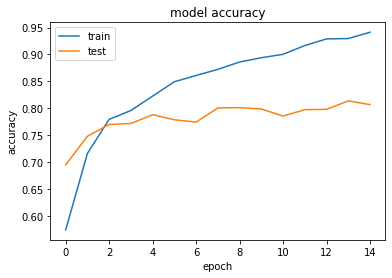

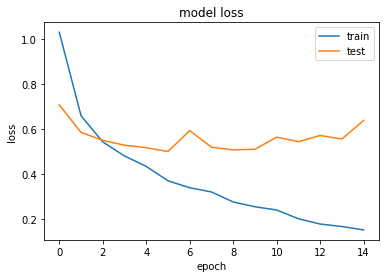

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()